In [1]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
from math import *
import numpy as np
from scipy.linalg import null_space
from itertools import product
from scipy.spatial import ConvexHull
import pandas as pd

# Creation of patterns

## Quasiperiodic

### Inicialitzation

In [2]:
class Point:
    def __init__(self, x, y, z, t):
        self.x=x
        self.y=y
        self.z=z        
        self.t=t
        self.coords=np.array([x, y, z, t])
        self.lambda_=None
        self.mu_=None
        self.gamma_=None
        self.delta_=None
        self.proj_e=None
        self.proj_eint=None
        self.lambda_ort=None
        self.mu_ort=None
        self.gamma_ort=None
        self.delta_ort=None

    def set_projections(self, A_inv, v, w, r, s):
        params = np.dot(A_inv, self.coords)
        self.lambda_ = params[0]
        self.mu_ = params[1]
        self.gamma_ = params[2]
        self.delta_ = params[3]
        self.proj_e = self.lambda_ * v + self.mu_ * w
        self.proj_eint = self.gamma_ * r + self.delta_ * s
    
    def set_projections_ort(self, A_ort_inv):
        params_ort = np.dot(A_ort_inv, self.coords)
        self.lambda_ort = params_ort[0]
        self.mu_ort = params_ort[1]
        self.gamma_ort = params_ort[2]
        self.delta_ort = params_ort[3]

In [3]:
lattice = [Point(x, y, z, t) for x in range(-30, 31)
                                   for y in range(-30, 31)
                                   for z in range(-30, 31)
                                   for t in range(-30, 31)]

cell_vertices = [Point(*vert) for vert in product([0, 1], repeat=4)]

# E=<v,w>, Eint=<r,s>
v=np.array([1, sqrt(2)/2, 0, -sqrt(2)/2])
w=np.array([0, sqrt(2)/2, 1, sqrt(2)/2])


### Construction of Eint

In [4]:
A = np.vstack([v, w])
ortho_basis = null_space(A)
r=ortho_basis[:, 0]
s=ortho_basis[:, 1]

### Projections

In [ ]:
# Build the matrix with v, w, r, s as columns
A = np.column_stack([v, w, r, s]) 
A_inv = np.linalg.inv(A)

In [6]:
for p in lattice:
    p.set_projections(A_inv, v, w, r, s)

for p in cell_vertices:
    p.set_projections(A_inv, v, w, r, s)

### Ortonormalization

In [ ]:
# Orthonormalize v and w to obtain an orthonormal basis of E
v_ort = v / np.linalg.norm(v)
w_proj = w - np.dot(w, v_ort) * v_ort
w_ort = w_proj / np.linalg.norm(w_proj)

# Orthonormalize r and s to obtain an orthonormal basis of Eint
r_ort = r / np.linalg.norm(r)
s_proj = s - np.dot(s, r_ort) * r_ort
s_ort = s_proj / np.linalg.norm(s_proj)

In [ ]:
# Build the orthonormal change of basis matrix and its inverse
A_ort = np.column_stack([v_ort, w_ort, r_ort, s_ort])
A_ort_inv = np.linalg.inv(A_ort)

In [ ]:
# Assign the new orthonormal coordinates to each point
for p in lattice:
    p.set_projections_ort(A_ort_inv)

for p in cell_vertices:
    p.set_projections_ort(A_ort_inv)

### Window

In [ ]:
cell_proj = []
for vert in cell_vertices:
    cell_proj.append([vert.gamma_ort, vert.delta_ort])  
cell_proj = np.array(cell_proj)

In [ ]:
shift_1 = np.array([1/100, 1/100])  
shift_2 = np.array([(-1/3)/100, -1/100])  

window_center_orig = np.mean(cell_proj, axis=0)
window_center_1 = window_center_orig + shift_1
window_center_2 = window_center_orig + shift_2

cell_proj_centered_orig = cell_proj - window_center_orig
cell_proj_centered_1 = cell_proj - window_center_1
cell_proj_centered_2 = cell_proj - window_center_2

cell_proj_centered_orig = np.array(cell_proj_centered_orig)
cell_proj_centered_1 = np.array(cell_proj_centered_1)
cell_proj_centered_2 = np.array(cell_proj_centered_2)

In [12]:
# Window original
hull_orig = ConvexHull(cell_proj_centered_orig)
cell_proj_convex_orig = cell_proj_centered_orig[hull_orig.vertices]
window_path_orig = Path(cell_proj_convex_orig)

# Window 1/2
hull_1 = ConvexHull(cell_proj_centered_1)
cell_proj_convex_1 = cell_proj_centered_1[hull_1.vertices]
window_path_1 = Path(cell_proj_convex_1)

# Window 1/3
hull_2 = ConvexHull(cell_proj_centered_2)
cell_proj_convex_2 = cell_proj_centered_2[hull_2.vertices]
window_path_2 = Path(cell_proj_convex_2)

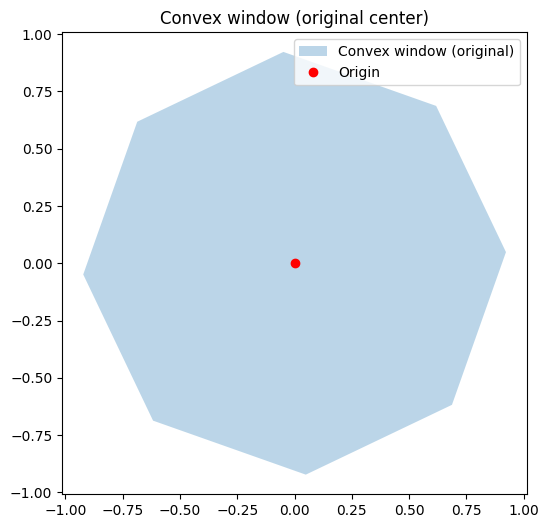

In [13]:
plt.figure(figsize=(6,6))
plt.fill(cell_proj_convex_orig[:,0], cell_proj_convex_orig[:,1], alpha=0.3, 
label='Convex window (original)')
plt.plot(0, 0, 'ro', label='Origin')
plt.axis('equal')
plt.legend()
plt.title('Convex window (original center)')
plt.show()

In [ ]:
# Functions for each window
def is_in_window_orig(point):
    return window_path_orig.contains_point([point.gamma_ort, point.delta_ort])

def is_in_window_1(point):
    return window_path_1.contains_point([point.gamma_ort, point.delta_ort])

def is_in_window_2(point):
    return window_path_2.contains_point([point.gamma_ort, point.delta_ort])

### Starting the process

In [ ]:
# Filter points for each window
strip_points_orig = [p for p in lattice if is_in_window_orig(p)]
strip_points_1 = [p for p in lattice if is_in_window_1(p)]
strip_points_2 = [p for p in lattice if is_in_window_2(p)]

In [ ]:
# Projection for each window
proj_points_ort_orig = np.array([[p.lambda_ort, p.mu_ort] for p in strip_points_orig])
proj_points_ort_1 = np.array([[p.lambda_ort, p.mu_ort] for p in strip_points_1])
proj_points_ort_2 = np.array([[p.lambda_ort, p.mu_ort] for p in strip_points_2])

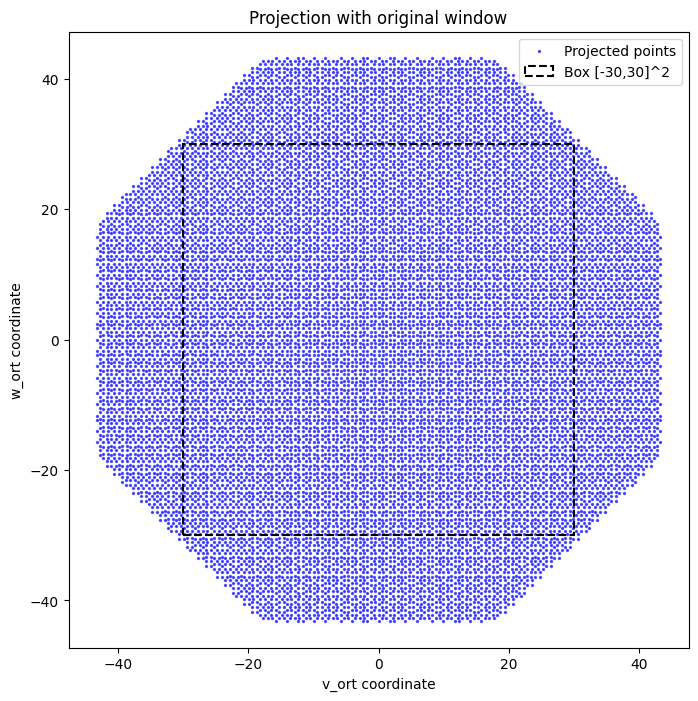

In [ ]:

plt.figure(figsize=(8,8))
plt.scatter(proj_points_ort_orig[:,0], proj_points_ort_orig[:,1], s=2, color='blue', alpha=0.6, label='Projected points')
plt.xlabel('v_ort coordinate')
plt.ylabel('w_ort coordinate')
plt.title('Projection with original window')
plt.axis('equal')

square = plt.Rectangle((-30, -30), 60, 60, fill=False, color='black', linewidth=1.5, linestyle='--', label='Box [-30,30]^2')
plt.gca().add_patch(square)
plt.legend(loc='upper right')
plt.show()


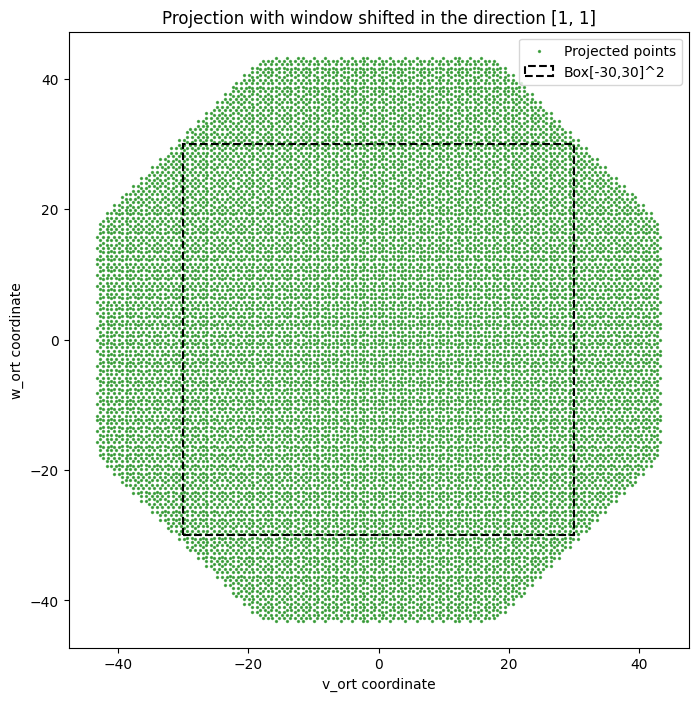

In [40]:
plt.figure(figsize=(8,8))
plt.scatter(proj_points_ort_1[:,0], proj_points_ort_1[:,1], s=2, color='green', alpha=0.6, label='Projected points')
plt.xlabel('v_ort coordinate')
plt.ylabel('w_ort coordinate')
plt.title('Projection with window shifted in the direction [1, 1]')
plt.axis('equal')
# Add the square border
square = plt.Rectangle((-30, -30), 60, 60, fill=False, color='black', linewidth=1.5, linestyle='--', label='Box[-30,30]^2')
plt.gca().add_patch(square)
plt.legend(loc='upper right')
plt.show()

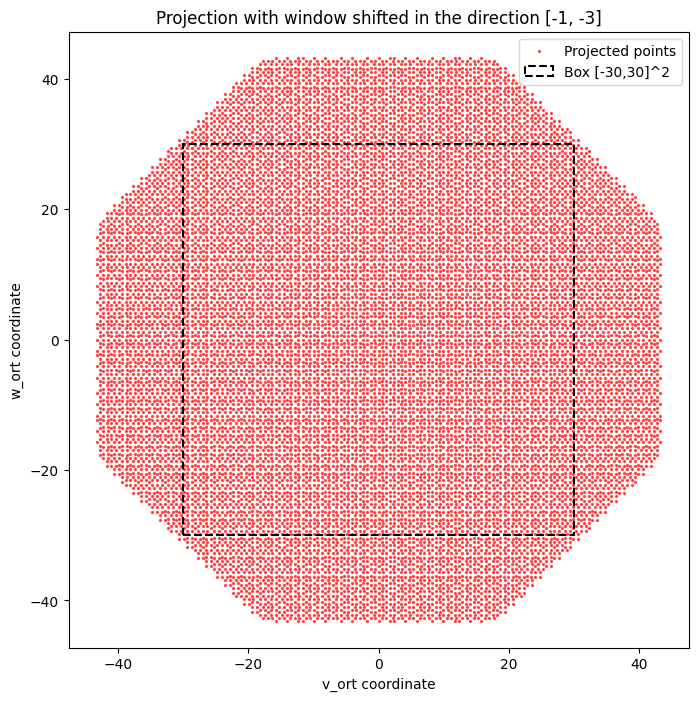

In [41]:
plt.figure(figsize=(8,8))
plt.scatter(proj_points_ort_2[:,0], proj_points_ort_2[:,1], s=2, color='red', alpha=0.6, label='Projected points')
plt.xlabel('v_ort coordinate')
plt.ylabel('w_ort coordinate')
plt.title('Projection with window shifted in the direction [-1, -3]')
plt.axis('equal')
square = plt.Rectangle((-30, -30), 60, 60, fill=False, color='black', linewidth=1.5, linestyle='--', label='Box [-30,30]^2')
plt.gca().add_patch(square)
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Define the box subsets according to the square of each case
box_orig = proj_points_ort_orig[
    (proj_points_ort_orig[:,0] >= -30) & (proj_points_ort_orig[:,0] <= 30) &
    (proj_points_ort_orig[:,1] >= -30) & (proj_points_ort_orig[:,1] <= 30)
]
box_1 = proj_points_ort_1[
    (proj_points_ort_1[:,0] >= -30) & (proj_points_ort_1[:,0] <= 30) &
    (proj_points_ort_1[:,1] >= -30) & (proj_points_ort_1[:,1] <= 30)
]
box_2 = proj_points_ort_2[
    (proj_points_ort_2[:,0] >= -30) & (proj_points_ort_2[:,0] <= 30) &
    (proj_points_ort_2[:,1] >= -30) & (proj_points_ort_2[:,1] <= 30)
]

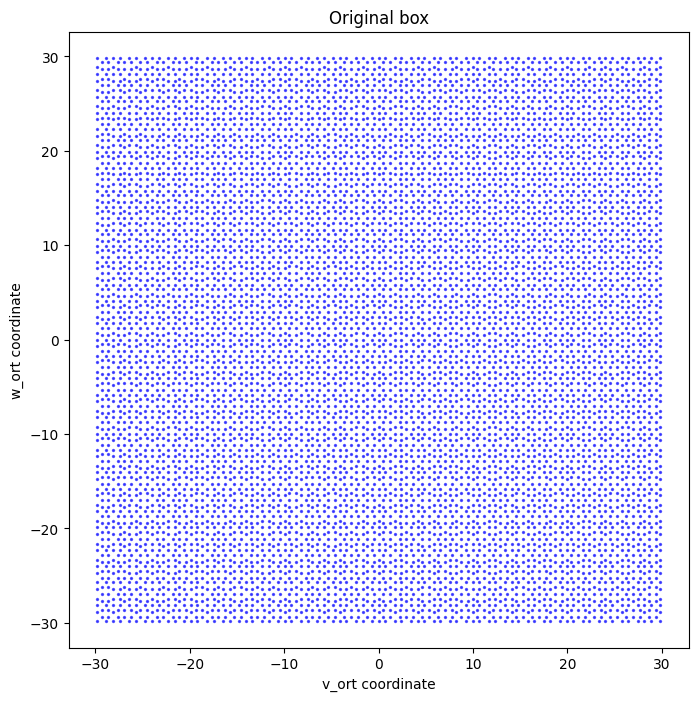

In [26]:
plt.figure(figsize=(8,8))
plt.scatter(box_orig[:,0], box_orig[:,1], s=2, color='blue', alpha=0.6)
plt.xlabel('v_ort coordinate')
plt.ylabel('w_ort coordinate')
plt.title('Original box')
plt.axis('equal')
plt.show()

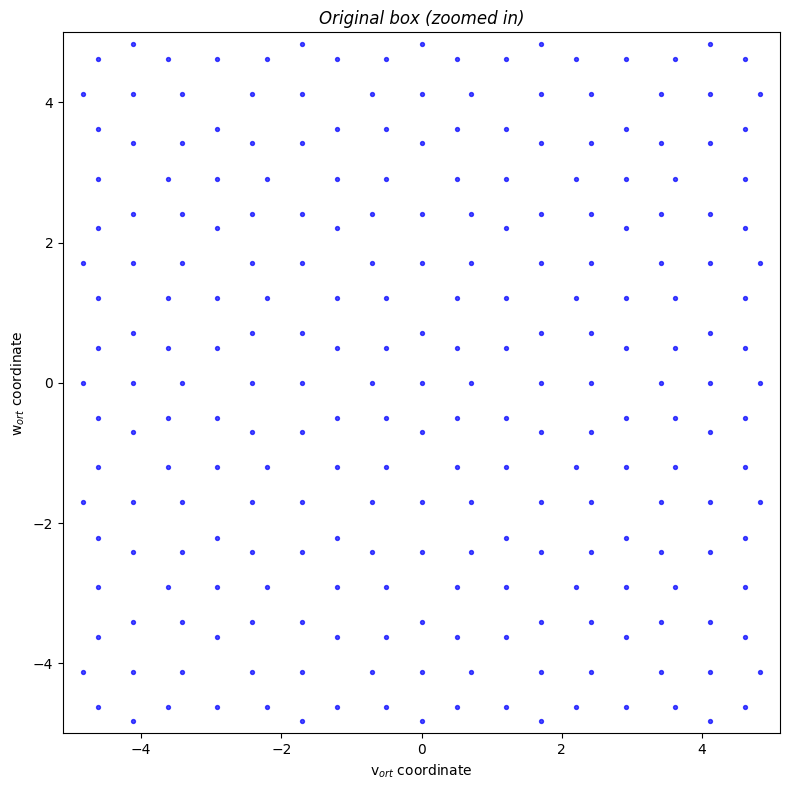

In [43]:
plt.figure(figsize=(8,8))
plt.scatter(box_orig[:,0], box_orig[:,1], s=8, color='blue', alpha=0.7)
plt.xlabel('v$_{ort}$ coordinate')
plt.ylabel('w$_{ort}$ coordinate')
plt.title('Original box (zoomed in)', fontstyle='italic')
plt.axis('equal')
plt.xlim(box_orig[:,0].mean() - 5, box_orig[:,0].mean() + 5)
plt.ylim(box_orig[:,1].mean() - 5, box_orig[:,1].mean() + 5)
plt.tight_layout()
plt.show()

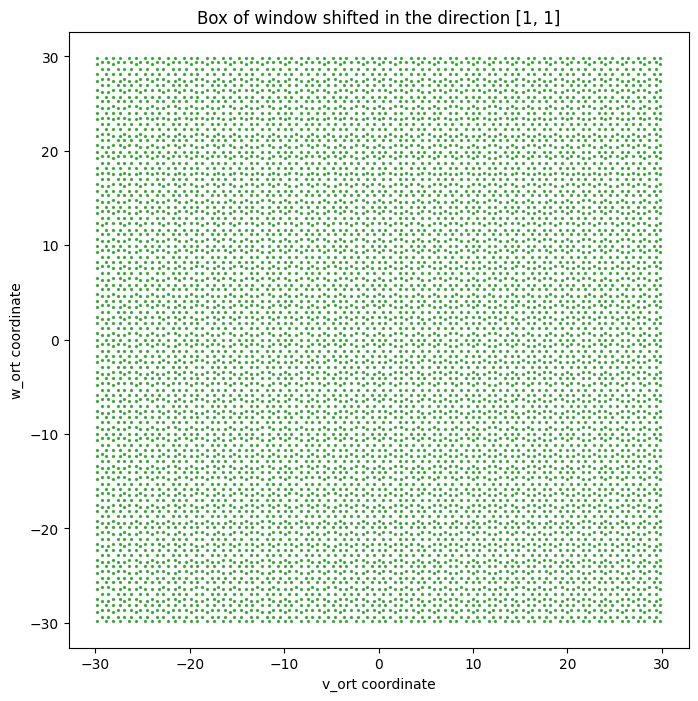

In [38]:
plt.figure(figsize=(8,8))
plt.scatter(box_1[:,0], box_1[:,1], s=2, color='green', alpha=0.6)
plt.xlabel('v_ort coordinate')
plt.ylabel('w_ort coordinate')
plt.title('Box of window shifted in the direction [1, 1]')
plt.axis('equal')
plt.show()

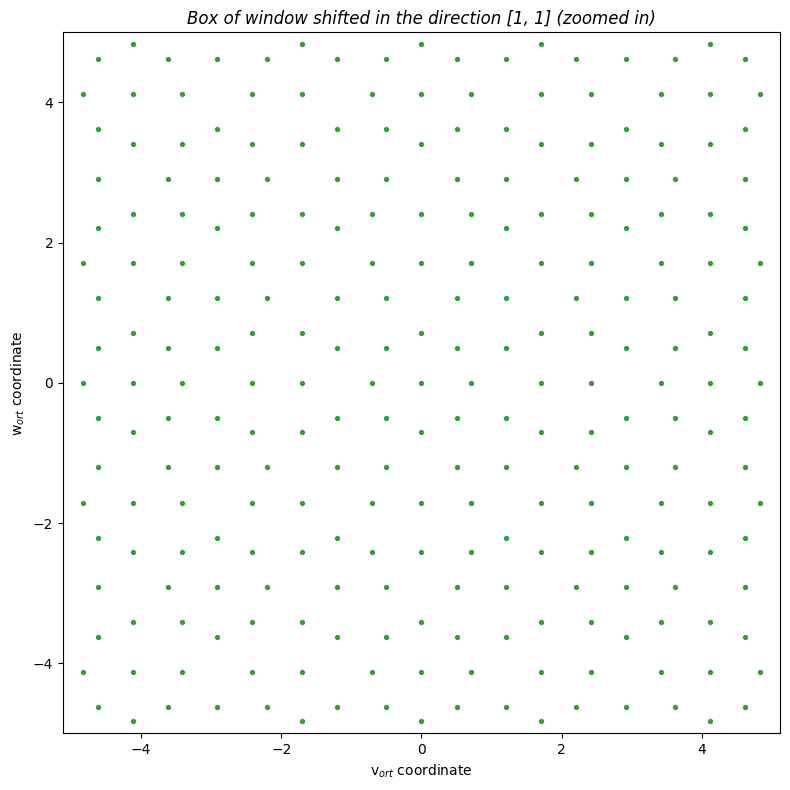

In [44]:
plt.figure(figsize=(8,8))
plt.scatter(box_1[:,0], box_1[:,1], s=8, color='green', alpha=0.7)
plt.xlabel('v$_{ort}$ coordinate')
plt.ylabel('w$_{ort}$ coordinate')
plt.title('Box of window shifted in the direction [1, 1] (zoomed in)', fontstyle='italic')
plt.axis('equal')
plt.xlim(box_1[:,0].mean() - 5, box_1[:,0].mean() + 5)
plt.ylim(box_1[:,1].mean() - 5, box_1[:,1].mean() + 5)
plt.tight_layout()
plt.show()

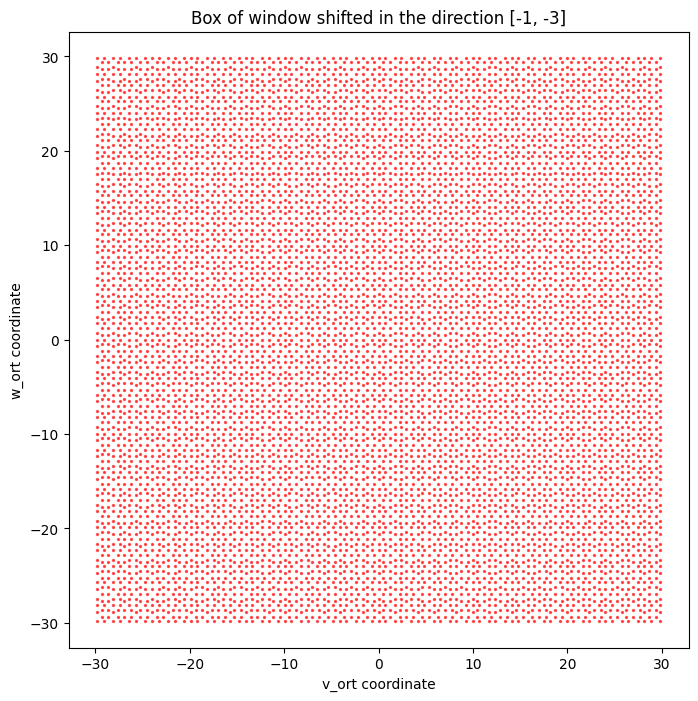

In [39]:
plt.figure(figsize=(8,8))
plt.scatter(box_2[:,0], box_2[:,1], s=2, color='red', alpha=0.6)
plt.xlabel('v_ort coordinate')
plt.ylabel('w_ort coordinate')
plt.title('Box of window shifted in the direction [-1, -3]')
plt.axis('equal')
plt.show()

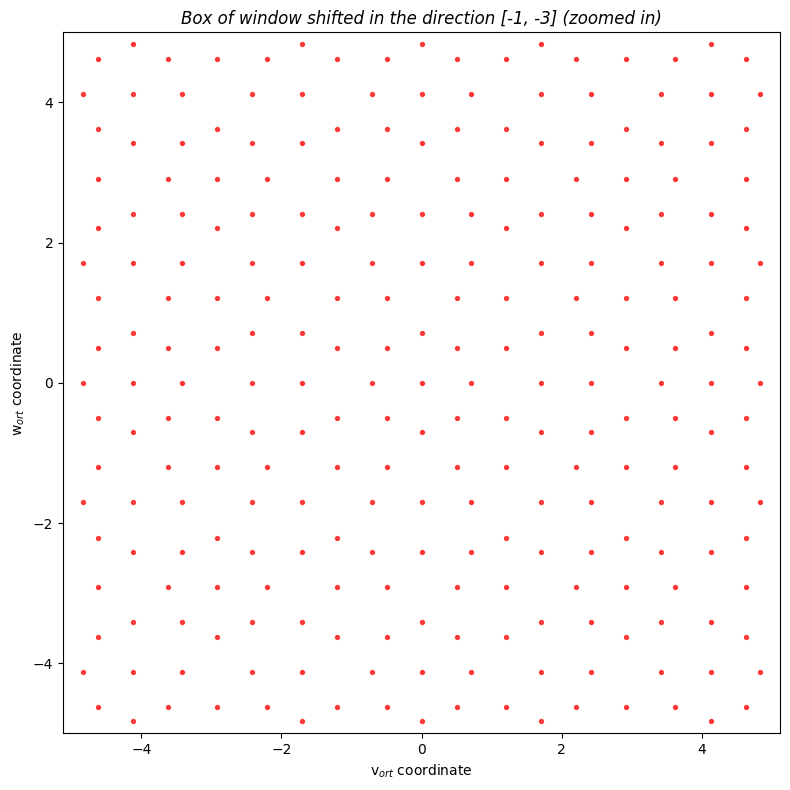

In [46]:
plt.figure(figsize=(8,8))
plt.scatter(box_2[:,0], box_2[:,1], s=8, color='red', alpha=0.7)
plt.xlabel('v$_{ort}$ coordinate')
plt.ylabel('w$_{ort}$ coordinate')
plt.title('Box of window shifted in the direction [-1, -3] (zoomed in)', fontstyle='italic')
plt.axis('equal')
plt.xlim(box_2[:,0].mean() - 5, box_2[:,0].mean() + 5)
plt.ylim(box_2[:,1].mean() - 5, box_2[:,1].mean() + 5)
plt.tight_layout()
plt.show()

## Periodic

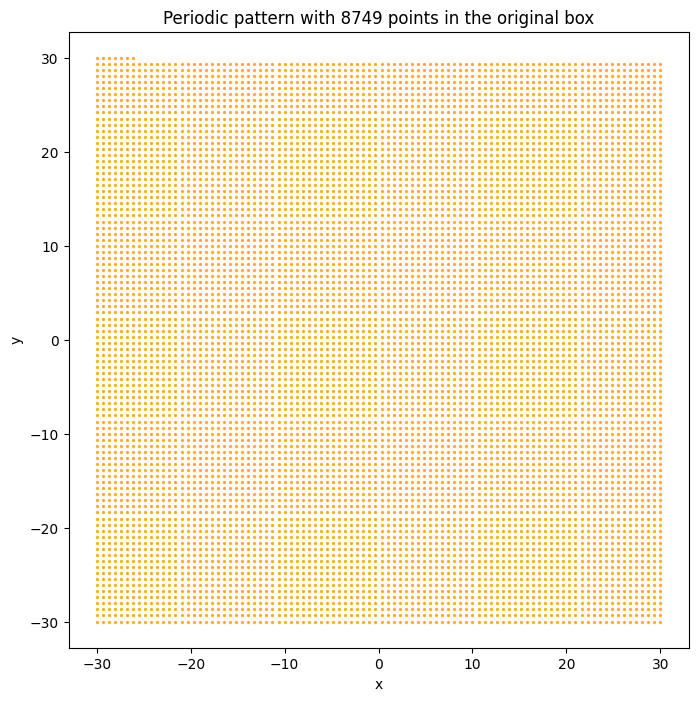

In [ ]:
# Use box_orig directly to define the points inside the box
proj_points_zoom = box_orig
n_points_zoom = proj_points_zoom.shape[0]

# Periodic grid with the same number of points
n_side = int(np.ceil(np.sqrt(n_points_zoom)))
x_vals = np.linspace(-30, 30, n_side)
y_vals = np.linspace(-30, 30, n_side)
xx, yy = np.meshgrid(x_vals, y_vals)
periodic_points = np.column_stack([xx.ravel(), yy.ravel()])
periodic_points = periodic_points[:n_points_zoom]

# Draw the periodic pattern
plt.figure(figsize=(8,8))
plt.scatter(periodic_points[:,0], periodic_points[:,1], s=2, color='orange', alpha=0.8)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Periodic pattern with {n_points_zoom} points in the original box')
plt.axis('equal')
plt.show()

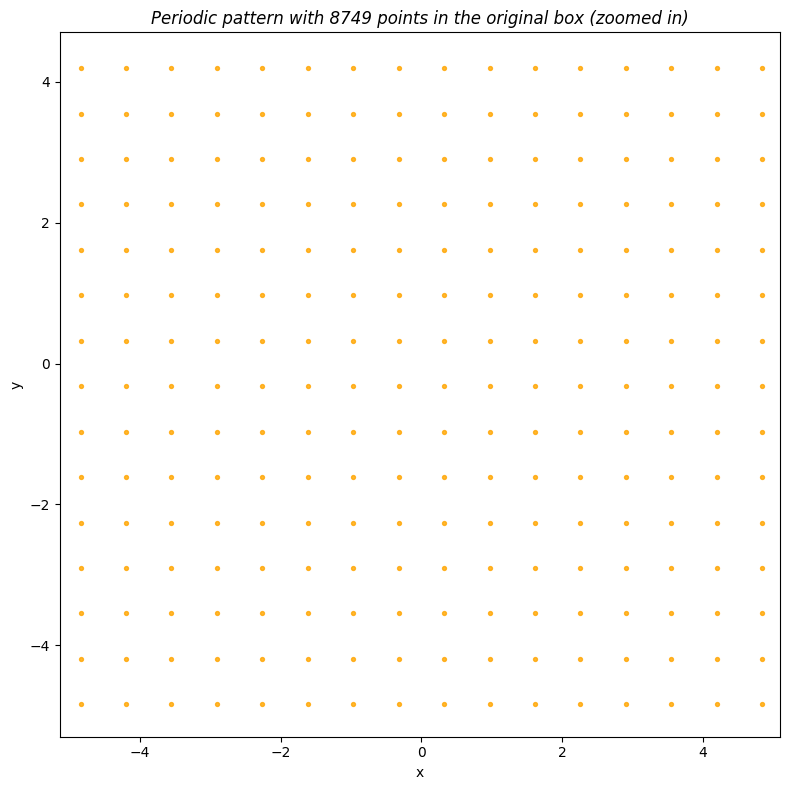

In [47]:
plt.figure(figsize=(8,8))
plt.scatter(periodic_points[:,0], periodic_points[:,1], s=8, color='orange', alpha=0.8)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Periodic pattern with {n_points_zoom} points in the original box (zoomed in)', fontstyle='italic')
plt.axis('equal')
plt.xlim(periodic_points[:,0].mean() - 5, periodic_points[:,0].mean() + 5)
plt.ylim(periodic_points[:,1].mean() - 5, periodic_points[:,1].mean() + 5)
plt.tight_layout()
plt.show()

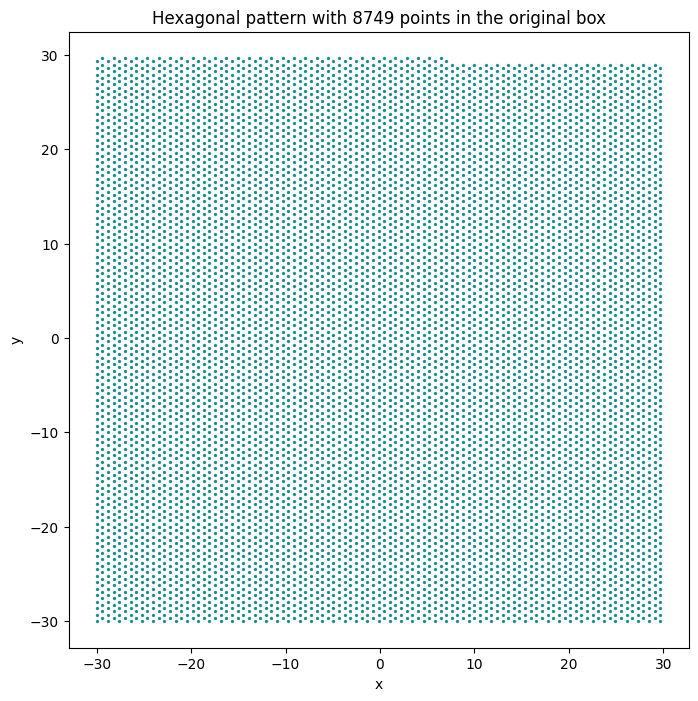

In [ ]:
# Window dimensions (already fixed by the box)
x_min, x_max = -30, 30
y_min, y_max = -30, 30
width = x_max - x_min
height = y_max - y_min

# Calculate the number of rows and columns for a hexagonal grid
area_total = width * height
a = np.sqrt((2 * area_total) / (3 * np.sqrt(3) * n_points_zoom))  # hexagon side

dx = a * 3/2
dy = a * np.sqrt(3)

n_cols = int(np.ceil(width / dx)) + 1
n_rows = int(np.ceil(height / dy)) + 1

hex_points = []
for row in range(n_rows):
    for col in range(n_cols):
        x = x_min + col * dx
        y = y_min + row * dy
        # Shift odd rows
        if col % 2 == 1:
            y += dy / 2
        # Only add if inside the window
        if x_min <= x <= x_max and y_min <= y <= y_max:
            hex_points.append([x, y])

hex_points = np.array(hex_points)
# If there are more points than n_points_zoom, take only the first ones
hex_points = hex_points[:n_points_zoom]

# Draw the hexagonal pattern
plt.figure(figsize=(8,8))
plt.scatter(hex_points[:,0], hex_points[:,1], s=2, color='teal', alpha=0.8)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Hexagonal pattern with {n_points_zoom} points in the original box')
plt.axis('equal')
plt.show()

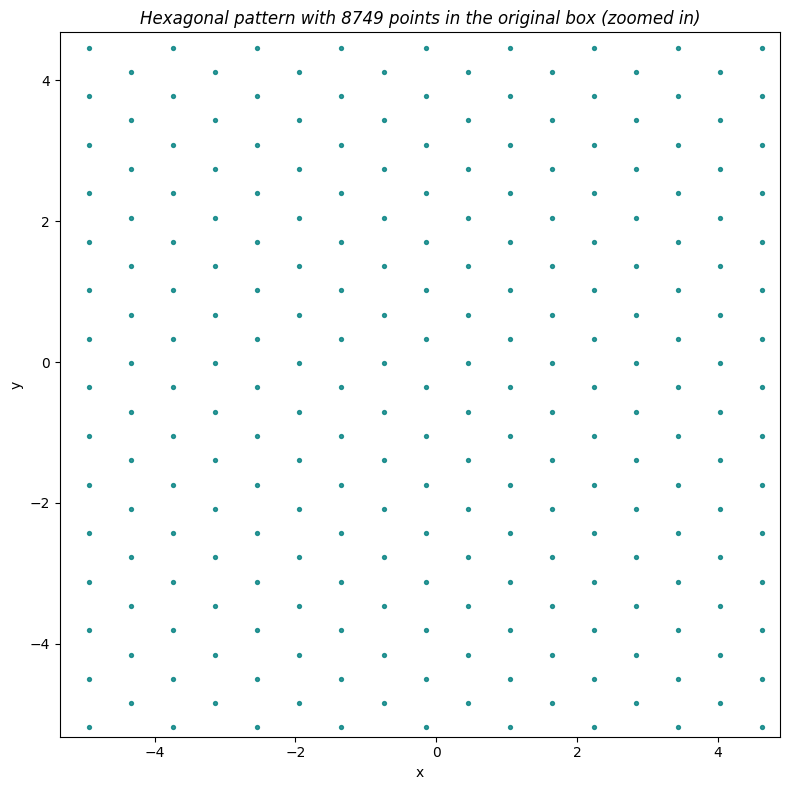

In [48]:
plt.figure(figsize=(8,8))
plt.scatter(hex_points[:,0], hex_points[:,1], s=8, color='teal', alpha=0.8)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Hexagonal pattern with {n_points_zoom} points in the original box (zoomed in)', fontstyle='italic')
plt.axis('equal')
plt.xlim(hex_points[:,0].mean() - 5, hex_points[:,0].mean() + 5)
plt.ylim(hex_points[:,1].mean() - 5, hex_points[:,1].mean() + 5)
plt.tight_layout()
plt.show()

## Random (Poisson)

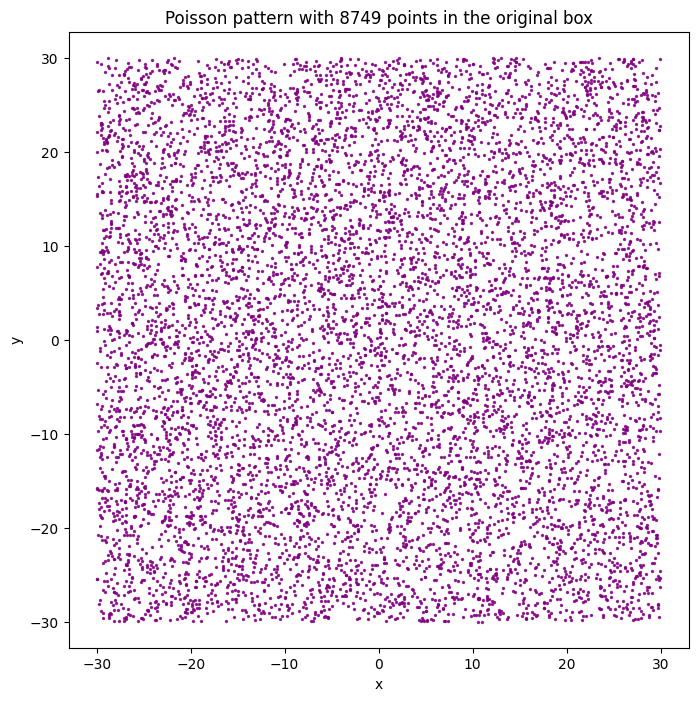

In [ ]:
# Number of points in the original window
n_points_zoom = proj_points_zoom.shape[0]

# Window dimensions
x_min, x_max = -30, 30
y_min, y_max = -30, 30
area = (x_max - x_min) * (y_max - y_min)

# Lambda density to have n_points_zoom on average
lambda_poisson = n_points_zoom / area

# Generate Poisson points until at least n_points_zoom
np.random.seed(42)  # For reproducibility
n_poisson = 0
while n_poisson < n_points_zoom:
    # Number of points according to Poisson
    n_poisson = np.random.poisson(lambda_poisson * area)
# Uniform coordinates inside the window
x_rand = np.random.uniform(x_min, x_max, n_poisson)
y_rand = np.random.uniform(y_min, y_max, n_poisson)
poisson_points = np.column_stack([x_rand, y_rand])

# If n_poisson > n_points_zoom, take only the first ones
poisson_points = poisson_points[:n_points_zoom]

# Draw the Poisson pattern
plt.figure(figsize=(8,8))
plt.scatter(poisson_points[:,0], poisson_points[:,1], s=2, color='purple', alpha=0.8)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Poisson pattern with {n_points_zoom} points in the original box')
plt.axis('equal')
plt.show()

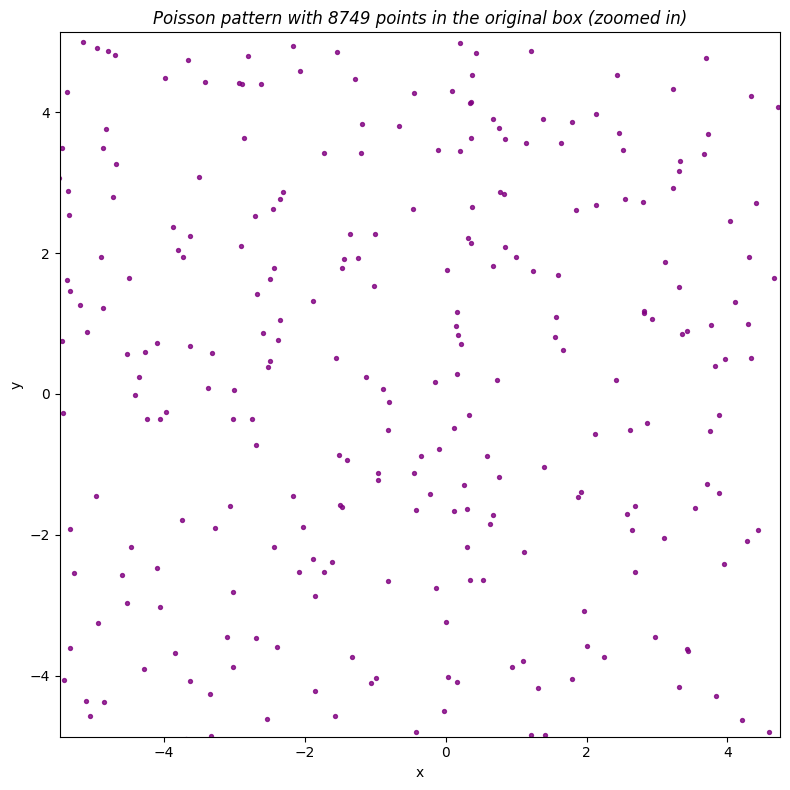

In [49]:
plt.figure(figsize=(8,8))
plt.scatter(poisson_points[:,0], poisson_points[:,1], s=8, color='purple', alpha=0.8)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Poisson pattern with {n_points_zoom} points in the original box (zoomed in)', fontstyle='italic')
plt.axis('equal')
plt.xlim(poisson_points[:,0].mean() - 5, poisson_points[:,0].mean() + 5)
plt.ylim(poisson_points[:,1].mean() - 5, poisson_points[:,1].mean() + 5)
plt.tight_layout()
plt.show()

# Number of variance


In [32]:
radius = np.logspace(np.log10(2), np.log10(15), 30)
print(radius)

[ 2.          2.14389999  2.29815358  2.46350572  2.64075494  2.83075724
  3.03443021  3.25275745  3.48679333  3.73766809  4.00659329  4.29486765
  4.60388335  4.93513273  5.29021551  5.67084648  6.07886386  6.51623808
  6.98508137  7.48765793  8.02639488  8.60389395  9.22294407  9.88653484
 10.59787097 11.36038772 12.17776755 13.05395786 13.99319005 15.        ]


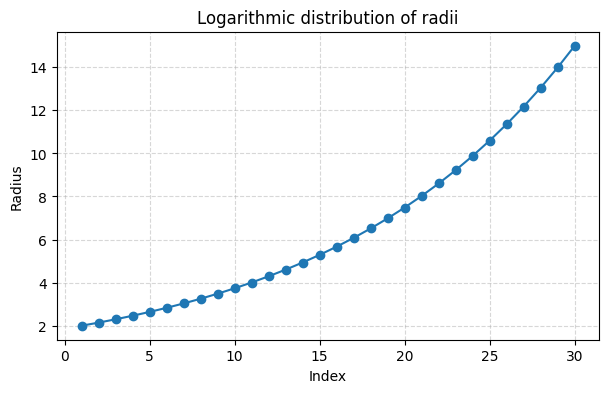

In [33]:
plt.figure(figsize=(7,4))
plt.plot(np.arange(1, len(radius)+1), radius, marker='o')
plt.xlabel('Index')
plt.ylabel('Radius')
plt.title('Logarithmic distribution of radii')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# Dictionary with the patterns and their points (arrays Nx2)
patterns = {
    'quasiperiodic_orig': box_orig,
    'quasiperiodic_1': box_1,
    'quasiperiodic_2': box_2,
    'periodic': periodic_points,
    'hexagonal': hex_points,
    'random': poisson_points
}

n_samples = 1000           # Number of samples per radius and pattern
results = []             # List to store the results

np.random.seed(1234)     # Seed for reproducibility

for pattern_name, points in patterns.items():
    x_min, x_max = -30, 30
    y_min, y_max = -30, 30

    for r in radius:     # For each radius
        # Subbox: area where the center of the circle can be without leaving the box
        sub_x_min = x_min + r
        sub_x_max = x_max - r
        sub_y_min = y_min + r
        sub_y_max = y_max - r

        if sub_x_min > sub_x_max or sub_y_min > sub_y_max:   # If the radius is too large
            results.append({
                'pattern': pattern_name,
                'radius': r,
                'mean_density': np.nan,
                'var_density': np.nan,
                'mean_count': np.nan,
                'var_count': np.nan
            })
            continue

        counts = []      # Number of points inside each circle
        densities = []   # Density of points inside each circle
        area_circle = np.pi * r**2

        for _ in range(n_samples):   
            cx = np.random.uniform(sub_x_min, sub_x_max)   # Random center X
            cy = np.random.uniform(sub_y_min, sub_y_max)   # Random center Y
            dists = np.sqrt((points[:,0] - cx)**2 + (points[:,1] - cy)**2)  # Distance from each point to the center
            n_in = np.sum(dists <= r)                     # Count points inside the circle
            counts.append(n_in)
            densities.append(n_in / area_circle)           # Local density

        results.append({                                  # Save results for this radius and pattern
            'pattern': pattern_name,
            'radius': r,
            'mean_density': np.mean(densities),
            'var_density': np.var(densities),
            'mean_count': np.mean(counts),
            'var_count': np.var(counts)
        })

# Results table
df = pd.DataFrame(results)
df_summary = df.pivot_table(index='radius', columns='pattern', values='var_count')
print(df.head())
df.head()

              pattern    radius  mean_density  var_density  mean_count  \
0  quasiperiodic_orig  2.000000      2.410163     0.012631      30.287   
1  quasiperiodic_orig  2.143900      2.410503     0.006071      34.807   
2  quasiperiodic_orig  2.298154      2.409242     0.008036      39.975   
3  quasiperiodic_orig  2.463506      2.414574     0.004932      46.036   
4  quasiperiodic_orig  2.640755      2.411201     0.004864      52.825   

   var_count  
0   1.994631  
1   1.265751  
2   2.212375  
3   1.792704  
4   2.334375  


,pattern,radius,mean_density,var_density,mean_count,var_count
0,quasiperiodic_orig,2.000000,2.410163,0.012631,30.287,1.994631
1,quasiperiodic_orig,2.143900,2.410503,0.006071,34.807,1.265751
2,quasiperiodic_orig,2.298154,2.409242,0.008036,39.975,2.212375
3,quasiperiodic_orig,2.463506,2.414574,0.004932,46.036,1.792704
4,quasiperiodic_orig,2.640755,2.411201,0.004864,52.825,2.334375


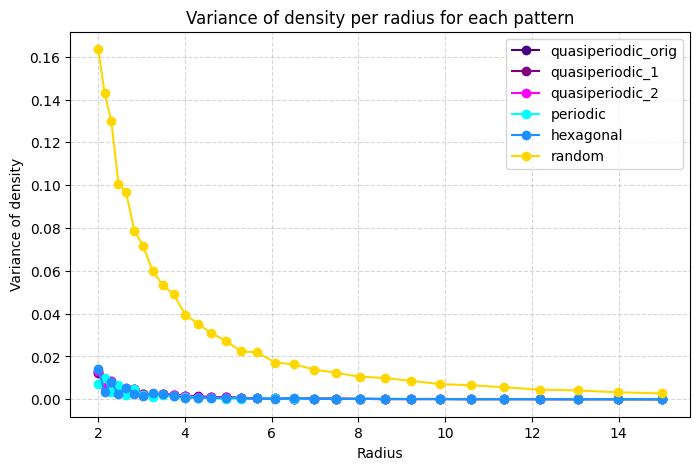

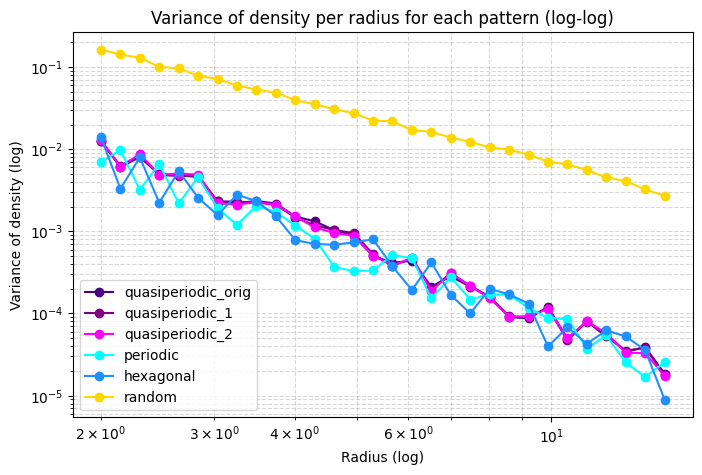

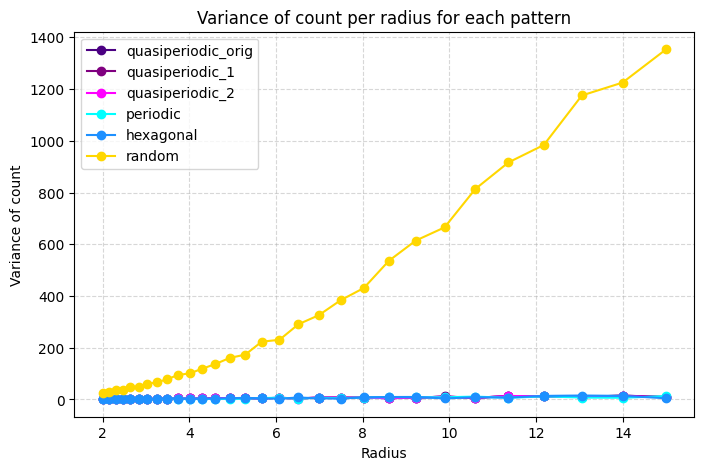

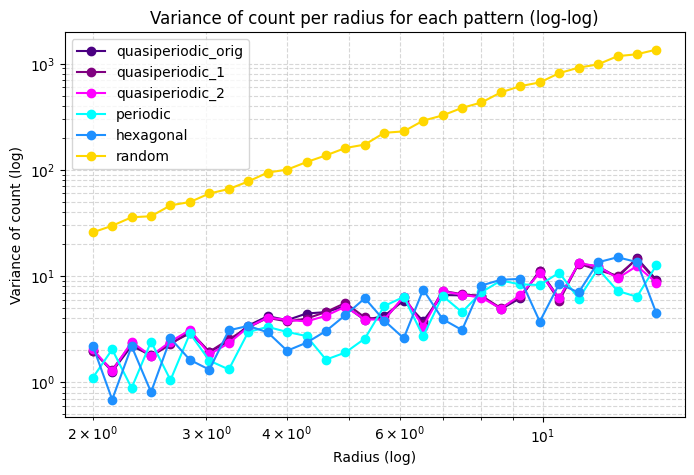

In [ ]:
pattern_colors = {
    'quasiperiodic_orig': 'indigo',
    'quasiperiodic_1': 'purple',
    'quasiperiodic_2': 'magenta',
    'periodic': 'aqua',
    'hexagonal': 'dodgerblue',
    'random': 'gold'
}

# 1. Variance of density (normal)
plt.figure(figsize=(8,5))
for pattern in df['pattern'].unique():
    plt.plot(
        df[df['pattern'] == pattern]['radius'],
        df[df['pattern'] == pattern]['var_density'],
        marker='o',
        label=pattern,
        color=pattern_colors.get(pattern, None)
    )
plt.xlabel('Radius')
plt.ylabel('Variance of density')
plt.title('Variance of density per radius for each pattern')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

# 2. Variance of density (log-log)
plt.figure(figsize=(8,5))
for pattern in df['pattern'].unique():
    plt.plot(
        df[df['pattern'] == pattern]['radius'],
        df[df['pattern'] == pattern]['var_density'],
        marker='o',
        label=pattern,
        color=pattern_colors.get(pattern, None)
    )
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (log)')
plt.ylabel('Variance of density (log)')
plt.title('Variance of density per radius for each pattern (log-log)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

# 3. Variance of count (normal)
plt.figure(figsize=(8,5))
for pattern in df['pattern'].unique():
    plt.plot(
        df[df['pattern'] == pattern]['radius'],
        df[df['pattern'] == pattern]['var_count'],
        marker='o',
        label=pattern,
        color=pattern_colors.get(pattern, None)
    )
plt.xlabel('Radius')
plt.ylabel('Variance of count')
plt.title('Variance of count per radius for each pattern')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

# 4. Variance of count (log-log)
plt.figure(figsize=(8,5))
for pattern in df['pattern'].unique():
    plt.plot(
        df[df['pattern'] == pattern]['radius'],
        df[df['pattern'] == pattern]['var_count'],
        marker='o',
        label=pattern,
        color=pattern_colors.get(pattern, None)
    )
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (log)')
plt.ylabel('Variance of count (log)')
plt.title('Variance of count per radius for each pattern (log-log)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

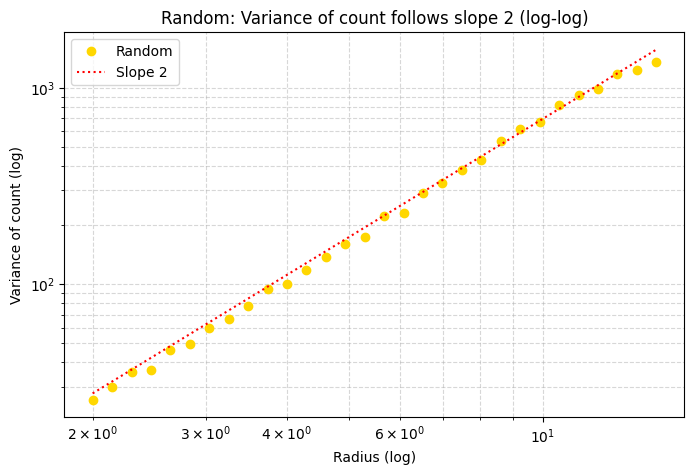

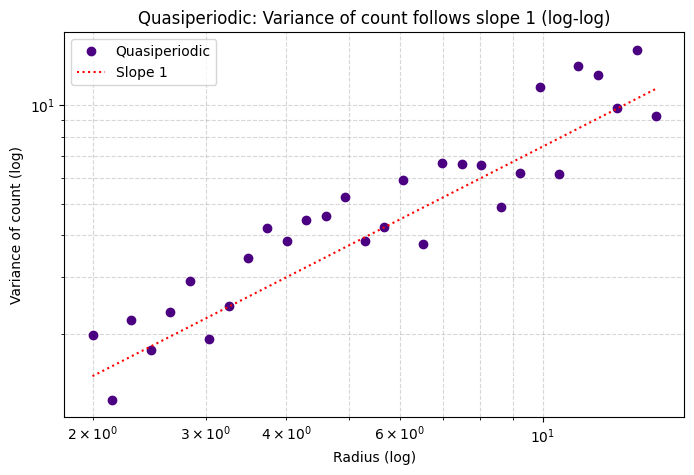

In [ ]:
# Random: show that it follows a line of slope 2
mask_random = (df['pattern'] == 'random') & (~np.isnan(df['radius'])) & (~np.isnan(df['var_count']))
radii_random = df.loc[mask_random, 'radius'].values
var_count_random = df.loc[mask_random, 'var_count'].values
valid_random = (radii_random > 0) & (var_count_random > 0)
log_r_random = np.log10(radii_random[valid_random])
log_var_random = np.log10(var_count_random[valid_random])

plt.figure(figsize=(8,5))
plt.plot(radii_random[valid_random], var_count_random[valid_random], 'o', label='Random', color=pattern_colors['random'])

# Slope 2 line passing through the midpoint
mid_idx = len(log_r_random) // 2
x0 = log_r_random[mid_idx]
y0 = log_var_random[mid_idx]
log_r_line = np.linspace(log_r_random.min(), log_r_random.max(), 100)
log_var_line = y0 + (log_r_line - x0) * 2  # slope 2
plt.plot(10**log_r_line, 10**log_var_line, ':', color='red', label='Slope 2')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (log)')
plt.ylabel('Variance of count (log)')
plt.title('Random: Variance of count follows slope 2 (log-log)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

# Quasiperiodic original (Fibonacci): show that it follows a line of slope 1
mask_fib = (df['pattern'] == 'quasiperiodic_orig') & (~np.isnan(df['radius'])) & (~np.isnan(df['var_count']))
radii_fib = df.loc[mask_fib, 'radius'].values
var_count_fib = df.loc[mask_fib, 'var_count'].values
valid_fib = (radii_fib > 0) & (var_count_fib > 0)
log_r_fib = np.log10(radii_fib[valid_fib])
log_var_fib = np.log10(var_count_fib[valid_fib])

plt.figure(figsize=(8,5))
plt.plot(radii_fib[valid_fib], var_count_fib[valid_fib], 'o', label='Quasiperiodic', color=pattern_colors['quasiperiodic_orig'])

# Slope 1 line passing through the midpoint
mid_idx = len(log_r_fib) // 2
x0 = log_r_fib[mid_idx]
y0 = log_var_fib[mid_idx]
log_r_line = np.linspace(log_r_fib.min(), log_r_fib.max(), 100)
log_var_line = y0 + (log_r_line - x0) * 1  # slope 1
plt.plot(10**log_r_line, 10**log_var_line, ':', color='red', label='Slope 1')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (log)')
plt.ylabel('Variance of count (log)')
plt.title('Quasiperiodic: Variance of count follows slope 1 (log-log)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

# Diffraction pattern

Calculant diffraction pattern (puntets) per a: quasiperiodic_orig


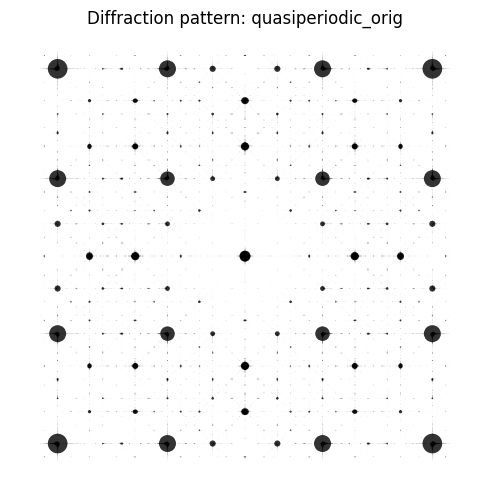

Calculant diffraction pattern (puntets) per a: quasiperiodic_1


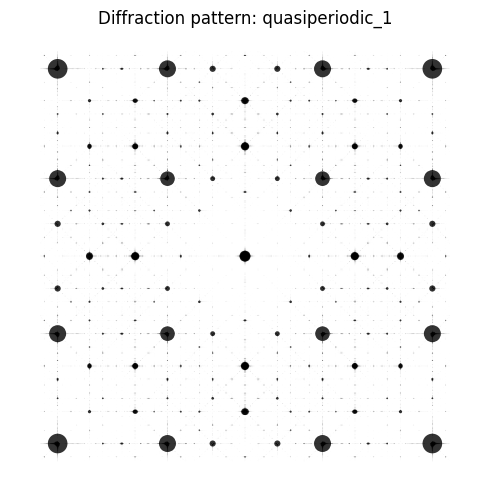

Calculant diffraction pattern (puntets) per a: quasiperiodic_2


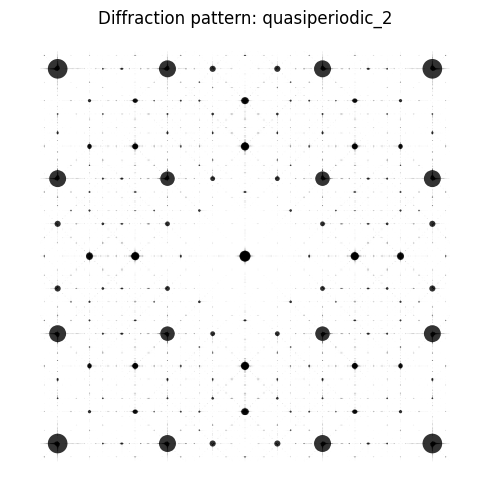

Calculant diffraction pattern (puntets) per a: periodic


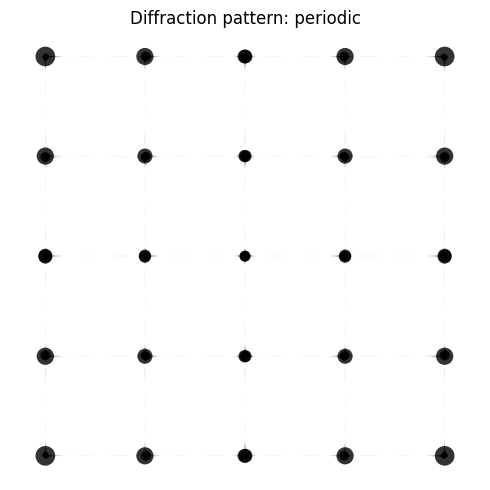

Calculant diffraction pattern (puntets) per a: hexagonal


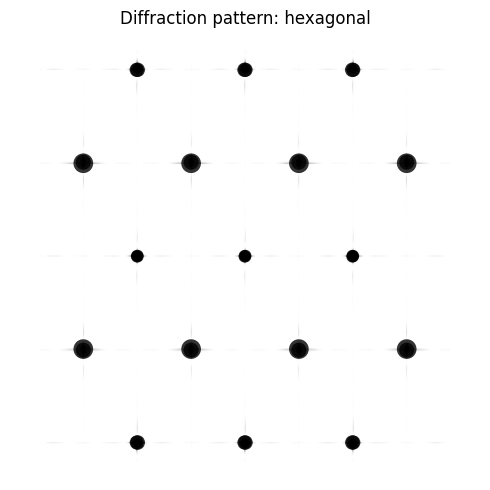

Calculant diffraction pattern (puntets) per a: random


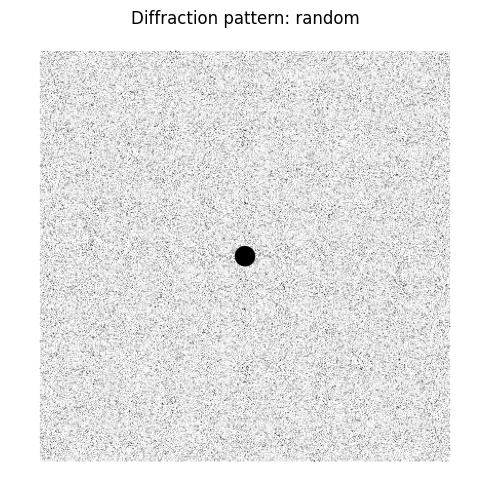

In [ ]:
kx_vals = np.linspace(-20, 20, 400)
ky_vals = np.linspace(-20, 20, 400)

for pattern_name, points in patterns.items():
    I_kk = np.zeros((len(kx_vals), len(ky_vals)))
    for i, kx in enumerate(kx_vals):
        for j, ky in enumerate(ky_vals):
            A_k = np.sum(np.exp(1j * (kx * points[:, 0] + ky * points[:, 1])))
            I_kk[i, j] = np.abs(A_k)**2

    # Prepare the grid coordinates
    KX, KY = np.meshgrid(kx_vals, ky_vals, indexing='ij')
    kx_flat = KX.flatten()
    ky_flat = KY.flatten()
    I_flat = I_kk.flatten()

    # Filter only points with significant intensity
    threshold = np.percentile(I_flat, 99) * 0.01  # Adjust if you want more/less points
    mask = I_flat > threshold

    plt.figure(figsize=(5,5))
    plt.scatter(
        kx_flat[mask], ky_flat[mask],
        s=I_flat[mask] / I_flat[mask].max() * 200,
        color='black', alpha=0.8, edgecolors='none'
    )
    plt.axis('equal')
    plt.axis('off')
    plt.title(f'Diffraction pattern: {pattern_name}')
    plt.tight_layout()
    plt.show()